## Task One - Regularization of The Curves

### Curve Fitting

In [74]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


#### Reading the Excel

In [75]:
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
            path_XYs.append(XYs)
    return path_XYs

#### Diffrent functions for estimation

In [76]:
def linear(x, m, b):
    return m * x + b

def circle(x, a, b, r):
    # Ensure the value inside sqrt is non-negative
    inside_sqrt = r**2 - (x - a)**2
    inside_sqrt[inside_sqrt < 0] = 0  # Clip negative values to 0
    return np.sqrt(inside_sqrt) + b

def ellipse(x, a, b, h, k):
    # Ensure the value inside sqrt is non-negative
    inside_sqrt = (1 - (x - h)**2 / a**2) * b**2
    inside_sqrt[inside_sqrt < 0] = 0  # Clip negative values to 0
    return np.sqrt(inside_sqrt) + k

#### Estimation of the Curves

In [77]:
def regularize_curves(XY):
    x_data, y_data = XY[:, 0], XY[:, 1]

    # Linear fit
    params_linear, _ = curve_fit(linear, x_data, y_data)
    
    # Circle fit
    initial_guess_circle = [x_data.mean(), y_data.mean(), (np.max(x_data) - np.min(x_data)) / 2]
    try:
        params_circle, _ = curve_fit(circle, x_data, y_data, p0=initial_guess_circle)
    except RuntimeError:
        params_circle = None
        print("Circle fit failed: Optimal parameters not found.")
    
    # Ellipse fit
    try:
        initial_guess_ellipse = [np.ptp(x_data)/2, np.ptp(y_data)/2, x_data.mean(), y_data.mean()]
        params_ellipse, _ = curve_fit(ellipse, x_data, y_data, p0=initial_guess_ellipse, maxfev=10000)
    except RuntimeError:
        params_ellipse = None
        print("Ellipse fit failed: Optimal parameters not found.")
    
    return params_linear, params_circle, params_ellipse

#### Plotting the Excel

In [78]:
# def plot(path_XYs):
#     fig, ax = plt.subplots(tight_layout=True, figsize=(8, 8))
#     colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
#     for i, XYs in enumerate(path_XYs):
#         c = colours[i % len(colours)]
#         for XY in XYs:
#             ax.plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
#     ax.set_aspect('equal')
#     plt.show()

def plot(path_XYs):
    fig, axs = plt.subplots(2, 2, tight_layout=True, figsize=(12, 12))
    axs = axs.flatten()  # Flatten the 2x2 array of axes for easy iteration
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    
    for i, XYs in enumerate(path_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            # Plot Original Curve
            axs[0].plot(XY[:, 0], XY[:, 1], c=c, linewidth=2)
            axs[0].set_title('Original Curve')

            # Regularize the curves
            params_linear, params_circle, params_ellipse = regularize_curves(XY)
            
            # Plot Linear Fit
            axs[1].plot(XY[:, 0], linear(XY[:, 0], *params_linear), color=c, linestyle='--')
            axs[1].set_title('Linear Fit')
            
            # Plot Circle Fit
            if params_circle is not None and len(params_circle) > 0:
                x_fit_circle = np.linspace(np.min(XY[:, 0]), np.max(XY[:, 0]), 100)
                axs[2].plot(x_fit_circle, circle(x_fit_circle, *params_circle), color=c, linestyle='--')
                axs[2].set_title('Circle Fit')
            
            # Plot Ellipse Fit if it didn't fail
            if params_ellipse is not None:
                x_fit_ellipse = np.linspace(np.min(XY[:, 0]), np.max(XY[:, 0]), 100)
                axs[3].plot(x_fit_ellipse, ellipse(x_fit_ellipse, *params_ellipse), color=c, linestyle='--')
                axs[3].set_title('Ellipse Fit')
    
    for ax in axs:
        ax.set_aspect('equal')
    
    plt.show()

Circle fit failed: Optimal parameters not found.


C:\Users\aniru\AppData\Roaming\Python\Python39\site-packages\scipy\optimize\_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


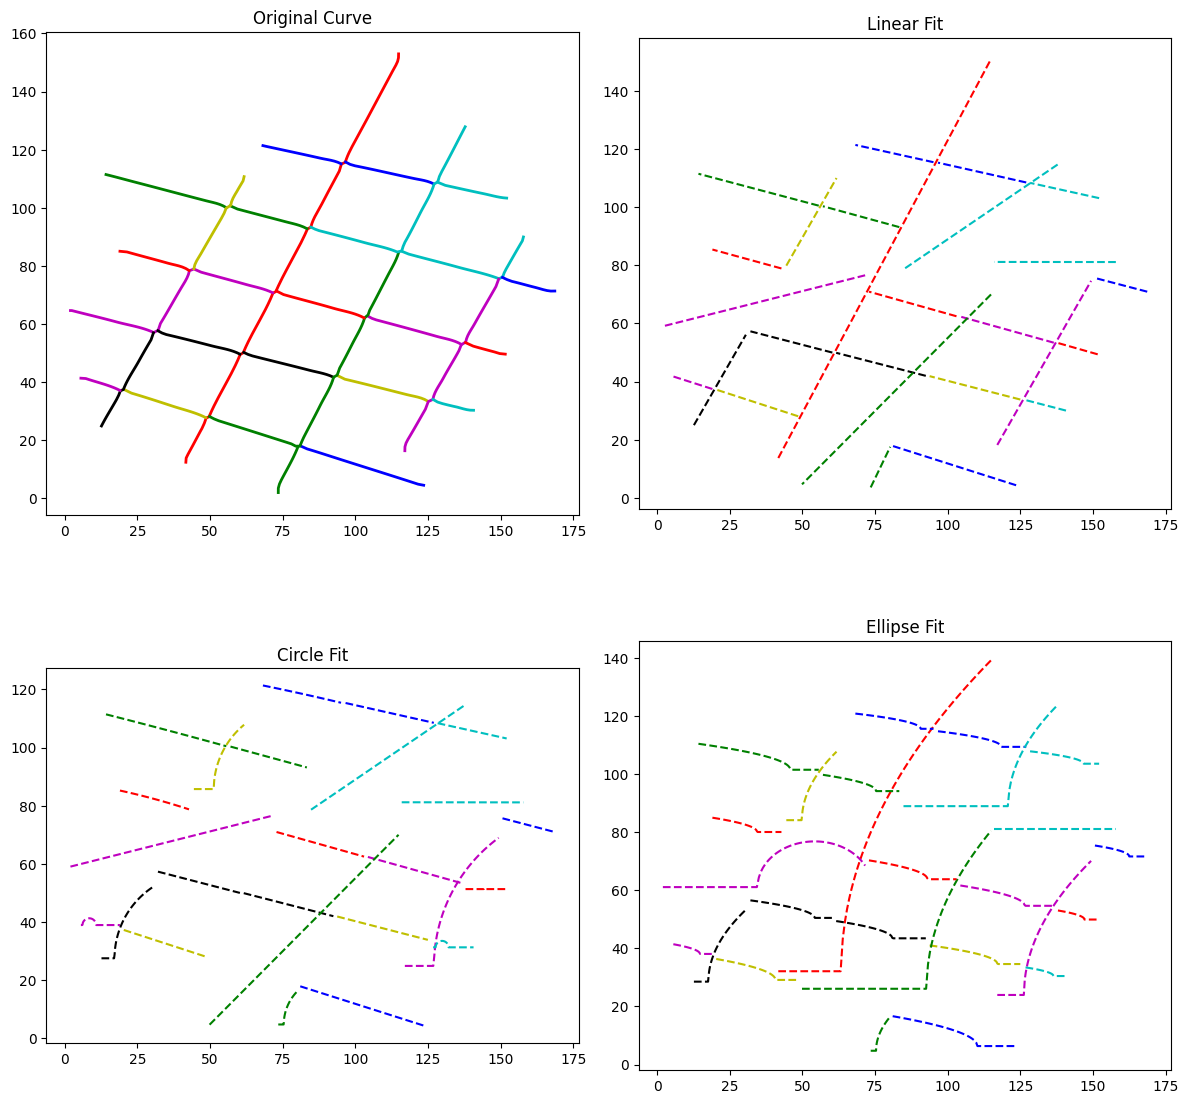

In [79]:
# Read data from Excel file
file_path = read_csv(r'C:\Users\aniru\Machine Learning\Computer Vision\Adobe Hackathon\Dataset\frag2.csv')  # Replace with the path to your Excel file 
plot(file_path)


### Shape Matching

In [80]:
from scipy import ndimage
from skimage.transform import hough_line, hough_circle, hough_ellipse, hough_line_peaks

In [81]:
def match_shapes(params_linear, params_circle, params_ellipse):
    # Match the line with a threshold slope
    if params_linear is not None:
        slope, intercept = params_linear
        if np.abs(slope) < 0.1:  # Example criteria for a horizontal line
            print(f"Line detected with slope: {slope} and intercept: {intercept}")

    # Match the circle with a threshold radius
    if params_circle is not None:
        a, b, r = params_circle
        if r > 10 and r < 100:  # Example radius criteria
            print(f"Circle detected with center: ({a}, {b}) and radius: {r}")
    
    # Match the ellipse with aspect ratio
    if params_ellipse is not None:
        a, b, h, k = params_ellipse
        aspect_ratio = a / b
        if aspect_ratio > 0.9 and aspect_ratio < 1.1:  # Example criteria for nearly circular ellipse
            print(f"Ellipse detected with center: ({h}, {k}) and aspect ratio: {aspect_ratio}")

    return None


In [82]:
def regularize_curves(XY):
    x_data, y_data = XY[:, 0], XY[:, 1]

    # Linear fit
    try:
        params_linear, _ = curve_fit(linear, x_data, y_data)
    except RuntimeError:
        params_linear = None
        print("Linear fit failed.")

    # Circle fit
    initial_guess_circle = [x_data.mean(), y_data.mean(), (np.max(x_data) - np.min(x_data)) / 2]
    try:
        params_circle, _ = curve_fit(circle, x_data, y_data, p0=initial_guess_circle)
    except RuntimeError:
        params_circle = None
        print("Circle fit failed: Optimal parameters not found.")
    
    # Ellipse fit
    try:
        initial_guess_ellipse = [np.ptp(x_data)/2, np.ptp(y_data)/2, x_data.mean(), y_data.mean()]
        params_ellipse, _ = curve_fit(ellipse, x_data, y_data, p0=initial_guess_ellipse, maxfev=10000)
    except RuntimeError:
        params_ellipse = None
        print("Ellipse fit failed: Optimal parameters not found.")
    
    return params_linear, params_circle, params_ellipse

In [83]:
# Example usage of match_shapes function
for XYs in path_XYs:
    for XY in XYs:
        params_linear, params_circle, params_ellipse = regularize_curves(XY)
        match_shapes(params_linear, params_circle, params_ellipse)


Circle detected with center: (12.54203297173332, 94.5998319393916) and radius: 26.105068494428284
Line detected with slope: -0.038687589839814684 and intercept: 50.606802914130974
Circle detected with center: (127.53415052576227, 138.44043593244336) and radius: 44.941674036342356
Line detected with slope: -0.013867933434969839 and intercept: 116.94095142337184
Line detected with slope: -0.06470722072242019 and intercept: 235.50506214168377
Circle detected with center: (253.73609478400036, 94.44321703887759) and radius: 32.30233976008355
Line detected with slope: 0.0010733414906658279 and intercept: 1.8743233100233536


In [84]:
def validate_regularization(path_XYs):
    for i, XYs in enumerate(path_XYs):
        for j, XY in enumerate(XYs):
            params_linear, params_circle, params_ellipse = regularize_curves(XY)
            print(f"Testing Shape {i+1}.{j+1}")
            match_shapes(params_linear, params_circle, params_ellipse)

# Call the validation function with your data
validate_regularization(path_XYs)


Testing Shape 1.1
Circle detected with center: (12.54203297173332, 94.5998319393916) and radius: 26.105068494428284
Testing Shape 2.1
Line detected with slope: -0.038687589839814684 and intercept: 50.606802914130974
Testing Shape 3.1
Circle detected with center: (127.53415052576227, 138.44043593244336) and radius: 44.941674036342356
Testing Shape 4.1
Line detected with slope: -0.013867933434969839 and intercept: 116.94095142337184
Testing Shape 5.1
Testing Shape 6.1
Line detected with slope: -0.06470722072242019 and intercept: 235.50506214168377
Testing Shape 7.1
Circle detected with center: (253.73609478400036, 94.44321703887759) and radius: 32.30233976008355
Testing Shape 8.1
Line detected with slope: 0.0010733414906658279 and intercept: 1.8743233100233536


In [89]:
# Function to visualize data and fitted shapes
def plot_with_shapes(path_XYs):
    colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    fig, ax = plt.subplots(figsize=(8, 8))

    for i, XYs in enumerate(path_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            x_data, y_data = XY[:, 0], XY[:, 1]

            # Plot the original data points
            ax.scatter(x_data, y_data, color=c, label='Original Data' if i == 0 else "")

            # Regularize the curves
            params_linear, params_circle, params_ellipse = regularize_curves(XY)
            
            # Plot Linear Fit
            if params_linear is not None:
                x_fit_linear = np.linspace(np.min(x_data), np.max(x_data), 100)
                ax.plot(x_fit_linear, linear(x_fit_linear, *params_linear), color='orange', linestyle='--')

            # Plot Circle Fit
            if params_circle is not None:
                x_fit_circle = np.linspace(np.min(x_data), np.max(x_data), 100)
                ax.plot(x_fit_circle, circle(x_fit_circle, *params_circle), color='blue', linestyle='--')

            # Plot Ellipse Fit
            if params_ellipse is not None:
                x_fit_ellipse = np.linspace(np.min(x_data), np.max(x_data), 100)
                ax.plot(x_fit_ellipse, ellipse(x_fit_ellipse, *params_ellipse), color='green', linestyle='--')
    
    ax.set_aspect('equal')
    plt.legend()
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Visualization of Detected Shapes')
    plt.show()

Circle fit failed: Optimal parameters not found.


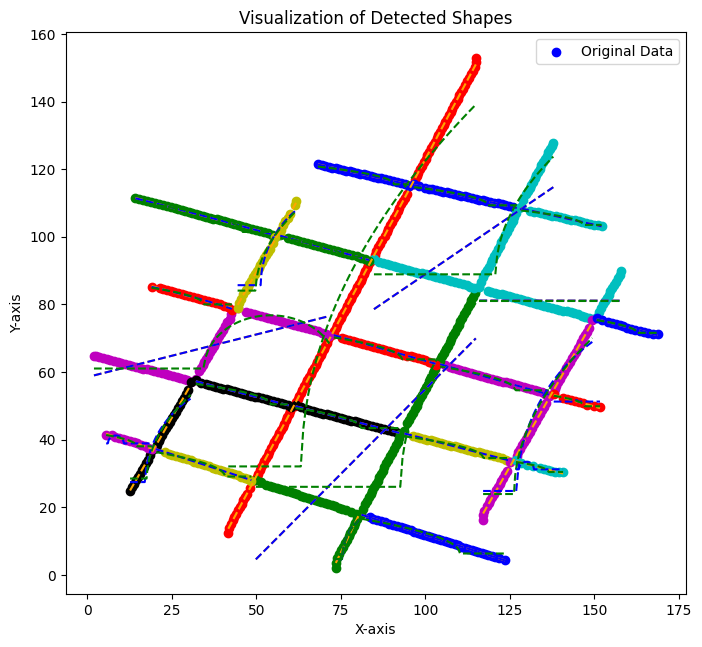

In [90]:
plot_with_shapes(file_path)